# Computational Social Science Project #2 

*Group number:* Team 1

*Group members:* Alex Huang, Madeline Adee, Xueqin Lin, Wan Nurul Naszeerah

*Semester:* Fall 2022


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send KQ a pull request on GitHub flagging the syntax that's tripping you up 

## 1. Introduction/Setup

#### a) Import relevant libraries
Add the other libraries you need for your code below and/or as you go. 

In [1]:
# import libraries you might need here 
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. 

In [2]:
diabetes = pd.read_csv('Diabetes with Population Info by County 2017.csv', 
                       #CountyFips needs to be a string so leading 0 isn't dropped (this is only if you want to make choropleth map): 
                       dtype={"CountyFIPS": str}) 

In [3]:
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [4]:
diabetes.head()
diabetes.Obesity_Number.value_counts()

No Data    78
3437        4
6054        3
2334        3
2413        3
           ..
4628        1
2522        1
2819        1
7054        1
2015        1
Name: Obesity_Number, Length: 2947, dtype: int64

In [5]:
pd.set_option('display.max_rows', 100) # tells pandas how many rows to display when printing so results don't get truncated

# look at the data types for each column in diabetes df 
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [6]:
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes.loc[~diabetes['Diabetes_Number'].str.isnumeric(),'Diabetes_Number'].unique()) 

['Suppressed']


In [7]:
# Now do the same as above, but for "Obesity_Number" :
print(diabetes.loc[~diabetes['Obesity_Number'].str.isnumeric(),'Obesity_Number'].unique()) 

['No Data']


In [8]:
print(diabetes.loc[~diabetes['Physical_Inactivity_Number'].str.isnumeric(),'Physical_Inactivity_Number'].unique()) 

['No Data']


The values contained in the two columns above making them objects (rather than integers) appear to be strings like "No Data" and "Suppressed." Let's drop those rows in the next section, and also recode Physical_Inactivity_Number to be an integer. 

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' to. 

In [9]:
# Diabetes
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"]  # note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype('int64') 

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"]
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype('int64') 

# Physical Inactivity
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"]
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype('int64') 

# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]
# change to numeric (specifically, integer or float?) from string (because originally included the "-" )
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)


We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [10]:
# select count variables to rc to percentages; make sure we leave out ratios and our population variable b/c these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 'sex and age_total population_sex ratio (males per 100 females)', 'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]

In [11]:
           
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') # recode all selected columns to numeric

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [12]:
pd.set_option('display.max_columns', None)
# inspect recoded values
diabetes_summary = diabetes[rc_cols].describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,0.224208
Obesity_Number,3112.0,0.251666,0.088946,0.476788
Physical_Inactivity_Number,3112.0,0.200861,0.064949,0.392285
race_total population_one race,3112.0,0.976059,0.713126,1.000000
race_total population_two or more races,3112.0,0.023941,0.000000,0.286874
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000
race_total population_one race_black or african american,3112.0,0.090215,0.000000,0.874123
race_total population_one race_american indian and alaska native,3112.0,0.019398,0.000000,0.924799
race_total population_one race_american indian and alaska native_cherokee tribal grouping,3112.0,0.001791,0.000000,0.409669


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. 

In [13]:
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population_65 years and over_1',
 'race_total population_two or more races_1',
 'sex and age_total population_18 years and over_1',
 'race_total population_one race_1',
 'sex and age_total population',
 'hispanic or latino and race_total population']

In [14]:
# now drop list of duplicate features from our df using the .drop() method
dibabetes = diabetes.drop(columns=duplicateColumnNames) 


In [15]:
diabetes.shape

(3112, 95)

## 2. Exploratory Data Analysis

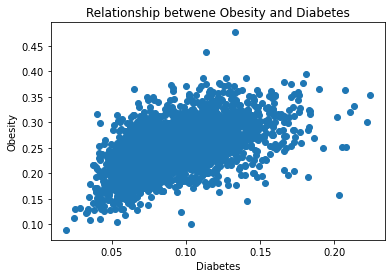

In [16]:
# insert your EDAs and interpretations in this section 
# 1. map diabetes number by county
# 2. scatterplot diabetes number and obesity_number 
plt.scatter(diabetes['Diabetes_Number'], diabetes['Obesity_Number'])
plt.title('Relationship betwene Obesity and Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Obesity')
plt.show()

# 3. scatterplot diabetes number by mean age

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'State' to be a categorical variable using `pd.get_dummies` and drop 'County' using `.drop()` because 'CountyFIPS' is already a unique identifier for the county. 

In [17]:
# create dummy features out of 'State' , which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['State'],  
                               drop_first = True) # only create 49 dummies by dropping first in category

In [18]:
diabetes_clean

,County,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_1,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_1,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other r

In [19]:
# drop 'County' variable
diabetes_clean = diabetes_clean.drop(labels = ['County'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

In [20]:
# look at first 10 rows of new data frame 
diabetes_clean.head(10)

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_1,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_1,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,his

### 3.2/3.3 Partition Data and Feature Selection

Now, we will partition our data to prepare it for the training process. We will use 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

In [21]:
from sklearn.model_selection import train_test_split

# Set y 
y = diabetes_clean['Diabetes_Number']

# X (everything except diabetes, our target)
X = diabetes_clean.drop(['Diabetes_Number'], 
                axis = 1)

We should also preprocess our data. Using the `preprocessing` module from sklearn, let's scale our features so that they are mean-centered.

In [22]:
from sklearn import preprocessing

X = preprocessing.scale(X)

We can also get rid of the 0 variance features using the `VarianceThreshold()` method from `feature_selection`. 

In [23]:
from sklearn import feature_selection

selector = feature_selection.VarianceThreshold(0)
X = selector.fit_transform(X)

And finally, let's split our data:

In [24]:
# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

## 4. Train Models

In [25]:
# train your three models in this section 
# OLS regression - maddy
# Ridge regression - lin
# Lasso regression  - wan
# Orthogonal Matching Pursuit (OMP) -- 

# Ridge regression 
ridge_reg = Ridge()
ridge_model = ridge_reg.fit(X_train, y_train)
ridge_reg_data = pd.DataFrame([ridge_model.coef_, diabetes_clean.columns]).T
ridge_reg_data.columns = ['Coefficient', 'Feature']

In [31]:
ridge_reg_data.dtypes
ridge_reg_data['Coefficient'] = pd.to_numeric(ridge_reg_data['Coefficient'])

Text(0.5, 1.0, 'Ridge Coefficients')

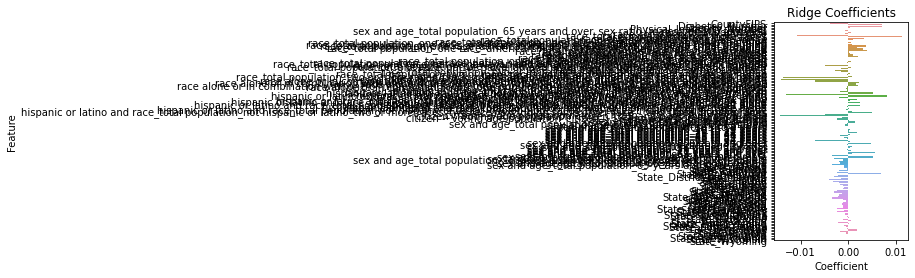

In [32]:
figure = plt.figure()
figure.subplots_adjust(wspace = .5, hspace=.5)
figure.add_subplot(1, 2, 1)
sns.barplot(x="Coefficient", y="Feature", data=ridge_reg_data).set_title("Ridge Coefficients")

## 5. Validate and Refine Models

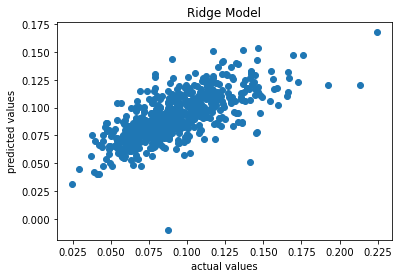

In [43]:
# use X_validation and y_validation data sets to evaluate and refine your models

# Ridge Model 
ridge_pred = ridge_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [44]:
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))
rmse(ridge_pred, y_validate)

0.01981338153284001

In [ ]:
# Orthogonal Matching Pursuit (OMP) 


## 6. Discussion Questions

In [1]:
# insert responses for discussion Qs here